In [104]:
# Import Libraries
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
from itertools import chain, combinations
import statsmodels.api as sm
from numpy.linalg import svd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

# Load Data

In [42]:
NHL = pd.read_csv("RegressionData.csv")
NHL.head(10)

,Rk,Team,Playoffs,AvAge,GP,GF,GA,SOW,SOL,SRS,...,S,Sper,SA,Svper,SO,W,L,OL,PTS,PTSper
0,1,Tampa Bay Lightning*,1,27.1,82,319,221,6,1,1.21,...,2620,12.2,2633,0.916,6,62,16,4,128,0.780
1,2,Boston Bruins*,1,28.7,82,257,212,2,3,0.52,...,2680,9.6,2416,0.912,9,49,24,9,107,0.652
2,3,Calgary Flames*,1,27.7,82,289,223,0,4,0.70,...,2656,10.9,2302,0.903,3,50,25,7,107,0.652
3,4,Washington Capitals*,1,28.8,82,274,248,4,1,0.35,...,2492,11.0,2584,0.904,4,48,26,8,104,0.634
4,5,New York Islanders*,1,28.4,82,223,191,5,5,0.38,...,2360,9.4,2534,0.925,11,48,27,7,103,0.628
5,6,San Jose Sharks*,1,29.4,82,289,258,0,3,0.30,...,2708,10.7,2323,0.889,5,46,27,9,101,0.616
6,7,Toronto Maple Leafs*,1,27.5,82,286,249,0,2,0.42,...,2736,10.5,2717,0.908,3,46,28,8,100,0.610
7,8,Nashville Predators*,1,28.9,82,236,212,4,2,0.31,...,2677,8.8,2460,0.914,7,47,29,6,100,0.610
8,9,Pittsburgh Penguins*,1,28.4,82,271,238,2,3,0.38,...,2731,9.9,2729,0.913,7,44,26,12,100,0.610
9,10,St. Louis Blues*,1,28.0,82,244,220,3,3,0.28,...,2604,9.4,2345,0.906,9,45,28,9,99,0.604


In [43]:
NHL.columns

Index(['Rk', 'Team', 'Playoffs', 'AvAge', 'GP', 'GF', 'GA', 'SOW', 'SOL',
       'SRS', 'SOS', 'GoalsperGame', 'EVGF', 'EVGA', 'PP', 'PPO', 'Pppercent',
       'PPA', 'PPOA', 'Pkpercent', 'SH', 'SHA', 'PIMperG', 'oPIMperG', 'S',
       'Sper', 'SA', 'Svper', 'SO', 'W', 'L', 'OL', 'PTS', 'PTSper'],
      dtype='object')

# Regression

In [44]:
regData = NHL.drop(["Rk", "Team", "Playoffs", "L", "OL", "PTS", "PTSper", "SRS"], axis = 1)
regData.head(10)

,AvAge,GP,GF,GA,SOW,SOL,SRS,SOS,GoalsperGame,EVGF,...,SH,SHA,PIMperG,oPIMperG,S,Sper,SA,Svper,SO,W
0,27.1,82,319,221,6,1,1.21,-0.05,6.59,233,...,12,3,9.5,9.4,2620,12.2,2633,0.916,6,62
1,28.7,82,257,212,2,3,0.52,-0.01,5.72,185,...,7,15,9.7,9.9,2680,9.6,2416,0.912,9,49
2,27.7,82,289,223,0,4,0.70,-0.06,6.24,218,...,18,7,8.5,9.8,2656,10.9,2302,0.903,3,50
3,28.8,82,274,248,4,1,0.35,-0.01,6.37,220,...,5,5,8.9,8.6,2492,11.0,2584,0.904,4,48
4,28.4,82,223,191,5,5,0.38,-0.01,5.05,184,...,6,1,7.9,7.7,2360,9.4,2534,0.925,11,48
5,29.4,82,289,258,0,3,0.30,-0.04,6.67,223,...,9,9,9.1,9.4,2708,10.7,2323,0.889,5,46
6,27.5,82,286,249,0,2,0.42,-0.01,6.52,235,...,5,9,6.1,6.7,2736,10.5,2717,0.908,3,46
7,28.9,82,236,212,4,2,0.31,-0.01,5.46,195,...,8,8,8.4,9.4,2677,8.8,2460,0.914,7,47
8,28.4,82,271,238,2,3,0.38,-0.01,6.21,203,...,12,15,8.4,8.0,2731,9.9,2729,0.913,7,44
9,28.0,82,244,220,3,3,0.28,-0.01,5.66,189,...,5,7,7.6,8.2,2604,9.4,2345,0.906,9,45


In [45]:
# returns powerset excluding empty set of input list
def all_subsets(sets):
    return chain(*map(lambda x: combinations(sets, x), range(1, len(sets)+1)))

def best_subset(dframe, method='aic'):
    assert method == 'aic' or method =='bic'

    #Setup variables
    x_vars = dframe.columns[:-1]
    y_var = dframe.columns[-1]
    best_score = np.Infinity
    best_subset = ''
    best_model = ''

    #Iterate through all possible subsets
    for subset in all_subsets(x_vars):
        #Fit our model, and fetch the score that we want
        explan_vars = '+'.join(subset)
        model = smf.ols(y_var+"~"+explan_vars, data=dframe).fit()
        score = getattr(model, method)

        #If we found a better subset, replace our old
        if score < best_score:
            best_score = score
            best_subset = explan_vars
            best_model = model
            print(best_subset)

    return (best_score, best_subset, best_model)

#best_score, best_subset, best_model = best_subset(regData, 'aic')

AvAge
GP
GF
SRS
SOW+SRS
SRS+SOS
SOW+SRS+SOS
GP+SOW+SRS+SOS
GF+GA+SOW+SOL
GF+GA+SRS+SOS
GF+SRS+SOS+GoalsperGame
SOW+SOL+SRS+SOS
SOW+SRS+SOS+PP


KeyboardInterrupt: 

Note that the subset method is computationaly expensive, which is why it was stopped here. I have it running in another notebook in the background, so hopefully it finishes sometime this century.

# PCA

In [58]:
class myPCA():
    
    def __init__(self, X, s = None):
        
        # Define X
        self.X = X
        
        # Define s if needed
        if s == None:
            self.s = self.X.shape[1]
        else:
            self.s = s
            
        # Calculate the svd
        self.U, self.Sigma, self.V = svd(self.X, full_matrices=False)
        
        self.a = 1
        
    def fit(self, mean = False, sd = False):
                
        mu = np.mean(self.X, axis = 0)
        standDev = np.std(self.X, axis = 0)
        
        if mean == True:
            self.X = self.X - mu
 
        if sd == True:
            self.X = self.X/standDev
            
        # Calculate the new svd
        self.U, self.Sigma, self.V = svd(self.X, full_matrices=False)
            
    def transform(self, x):
        
        self.a = x@self.V.T[:,:self.s]
        return self.a
        
            
    def project(self, x):
        X_ = self.transform(self.X)
        return np.inner(X_, self.V.T[:,:self.s])

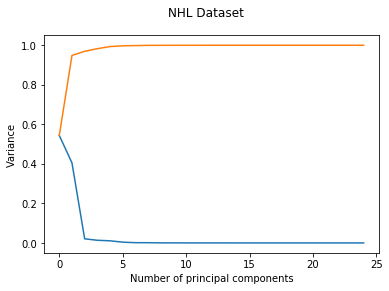

In [105]:
pcaData = NHL.drop(["Rk", "Team", "Playoffs", "L", "OL", "PTS", "PTSper", "W", "SRS"], axis = 1)

pca = myPCA(pcaData)
pca.fit(mean = True)
variance = pca.Sigma**2/(pca.Sigma**2).sum()
cvar = np.cumsum(variance)
plt.plot(variance)
plt.plot(cvar)
plt.xlabel("Number of principal components")
plt.ylabel("Variance")
plt.suptitle("NHL Dataset")
plt.show()

This indicates that the best number of components is around 2ish

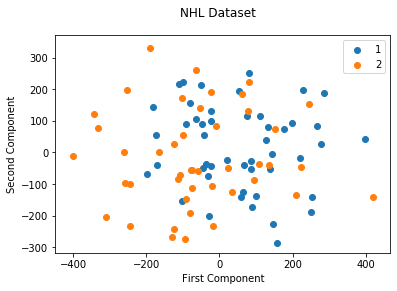

In [106]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pcaData)
for i in set(NHL.Playoffs):
    plt.scatter(principalComponents[:,0][NHL.Playoffs==i], principalComponents[:,1][NHL.Playoffs==i], label = i)
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.suptitle("NHL Dataset")
plt.legend()
plt.show()

Doesn't look like PCA is useful in classifying playoff teams.

In [115]:
# Split into data
X = pcaData
y = NHL.Playoffs
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)

# Random Forest

In [116]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [117]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.906
Mean accuracy score: 0.929


    1   2
1  16   0
2   2  10


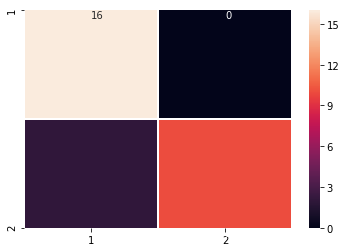

In [118]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=set(y), index=set(y))
annot_kws = {"ha": 'left',"va": 'top'}
ax = sns.heatmap(cm, linewidth=0.5, annot=True, annot_kws=annot_kws)
print(cm)
plt.show()

# Naive Bayes

In [119]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print("Accuracy: ", 1-(y_test!=y_pred).sum()/X_test.shape[0])

Number of mislabeled points out of a total 28 points : 3
Accuracy:  0.8928571428571429


    1  2
1  16  0
2   3  9


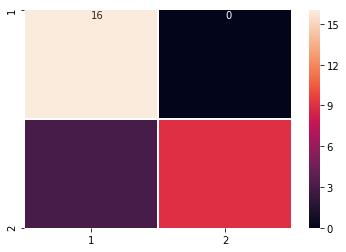

In [120]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=set(y), index=set(y))
annot_kws = {"ha": 'left',"va": 'top'}
ax = sns.heatmap(cm, linewidth=0.5, annot=True, annot_kws=annot_kws)
print(cm)
plt.show()

Naive bayes and Random forest result in similar predictions/accuracy